In [320]:
# Using cv2 weighted overlay

In [321]:
from PIL import Image
import torch
import os
import numpy as np
import pickle
from utils.utils import *
from utils.file_utils import save_pkl, load_pkl
from models.resnet_custom import resnet50_baseline
from models.model_clam import CLAM_MB, CLAM_SB
from torch.utils.data import DataLoader
from scipy.stats import percentileofscore
import matplotlib.pyplot as plt
from skimage.color import label2rgb
import cv2 as cv

In [322]:
drop_out = False
n_classes = 2
model_type = "clam_sb"
model_size = 'small'
exp_code = "exp_6" + "_s1"
ckpt_path = "s_0_checkpoint.pt"
results_dir = "image_sets/results"

data_dir = "image_sets/original/"
image_ext = ".tif"
patch_dir = "image_sets/patches/"
feat_dir = "image_sets/features/"
actual_feat_dir = "image_sets/patches/fungal_vs_nonfungal_resnet_features/pt_files/"

save_path = os.path.join(results_dir, exp_code, "heatmaps")
if not os.path.isdir(save_path):
    os.mkdir(save_path)

In [323]:
alpha = 1
beta = 0.5
gamma = 0.0
cmap='coolwarm'

In [324]:
heatmap_dict = load_pkl(os.path.join(results_dir, exp_code, "heatmap_dict.pkl"))

In [325]:
image_file = heatmap_dict[0]

image_name = image_file['filename']
attention_scores = image_file['attention_scores']
coords_list = image_file['coords_list']

In [326]:
if isinstance(cmap, str):
    cmap = plt.get_cmap(cmap)

img_path = os.path.join(data_dir, image_name+image_ext)
# orig_img = np.array(Image.open(img_path))
# orig_img = orig_img[0:1024, 0:1536] # No left-overs

orig_img = cv2.imread(img_path)
orig_img = orig_img[0:1024, 0:1536] # No left-overs

In [327]:
scores = attention_scores[0].copy()
scores = [float(x) for x in scores]
percentiles = []
for score in scores:
    percentile = percentileofscore(scores, score)
    percentiles.append(percentile/100)
print(scores)
print()
print(percentiles)

[0.019707337021827698, 0.014753628522157669, 0.02770865522325039, 0.062034204602241516, 0.05885422229766846, 0.010836946777999401, 0.068598173558712, 0.040113434195518494, 0.026387939229607582, 0.044676244258880615, 0.02658875659108162, 0.10758525133132935, 0.05781164765357971, 0.024182014167308807, 0.03905566409230232, 0.03275112435221672, 0.05890554189682007, 0.06915263086557388, 0.06452343612909317, 0.03985404595732689, 0.0343826562166214, 0.035348981618881226, 0.025171050801873207, 0.011016366071999073]

[0.16666666666666669, 0.125, 0.375, 0.8333333333333333, 0.75, 0.04166666666666667, 0.9166666666666667, 0.625, 0.2916666666666667, 0.6666666666666667, 0.33333333333333337, 1.0, 0.7083333333333333, 0.20833333333333331, 0.5416666666666666, 0.41666666666666663, 0.7916666666666667, 0.9583333333333333, 0.875, 0.5833333333333334, 0.45833333333333337, 0.5, 0.25, 0.08333333333333334]


In [328]:
heatmap_mask = Image.new("RGB", (1536, 1024), (255, 255, 255))
heatmap_mask = cv2.cvtColor(np.array(heatmap_mask), cv2.COLOR_RGB2BGR)

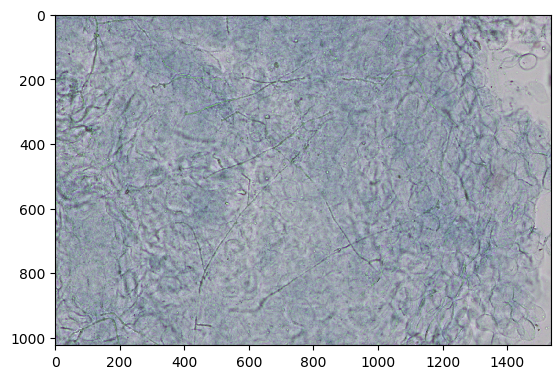

In [329]:
for index, score in enumerate(scores):
    x = 256 * coords_list[0][0][index].item() # Top left corner
    y = 256 * coords_list[0][1][index].item() # Top left corner
#     print(score, x, y)
    
    label = np.ones([256, 256, 3])
    label *= score
#     print(label)
    
#     print(x, y, x+patch_size[0], y+patch_size[1])
    heatmap_mask[x:x+patch_size[0], y:y+patch_size[1]] = label.copy()

# print(orig_img.shape)
# print(heatmap_mask.shape)

img_patch_heatmap = cv.addWeighted(np.array(orig_img), alpha, np.array(heatmap_mask), beta, gamma)
plt.imshow(img_patch_heatmap)